In [1]:
# Imports
import numpy as np
import pandas as pd
import os

In [2]:
# Print size of data
print("Size of Spam Data:", len(os.listdir('./Data/archive/spam/')))
print("Size of Ham Data:", len(os.listdir('./Data/archive/ham/')))

Size of Spam Data: 501
Size of Ham Data: 2551


In [3]:
# Import Raw Data
directory = './Data/archive/'
emails = []
labels = []
for label in ['ham/', 'spam/']:
    labelDirectory = os.listdir(directory + label)
    for file in labelDirectory:
        f = open((directory + label + file), 'r', encoding = 'latin-1')
        
        content = f.read()
        emails.append(content)
        labels.append(label)

In [4]:
# Convert to Dataframe
df = pd.DataFrame({'emails' : emails, 'labels': labels})

In [5]:
# Look at example email - we can see it contains headers, sender & content
df.iloc[0].emails

'From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002\nReturn-Path: <exmh-workers-admin@example.com>\nDelivered-To: zzzz@localhost.netnoteinc.com\nReceived: from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36\n\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)\nReceived: from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)\nReceived: from listman.example.com (listman.example.com [66.187.233.211]) by\n    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for\n    <zzzz-exmh@example.com>; Thu, 22 Aug 2002 12:34:53 +0100\nReceived: from listman.example.com (localhost.localdomain [127.0.0.1]) by\n    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002\n    07:35:02 -0400 (EDT)\nDelivered-To: exmh-workers@listman.example.com\nReceived: from int-mx1.corp.example.com (int-mx1.corp.example.com\n    [

In [6]:
# Check for imported null values in our data that could ruin it
df.isnull().sum()

emails    0
labels    0
dtype: int64

In [7]:
# Encode "spam/" & "ham/" to 0 & 1
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['labels'] = encoder.fit_transform(df['labels'])

In [8]:
# Convert email content to lowercase (Casing of words shouldn't effect spam or not)
df['emails'] = df['emails'].apply(lambda x:x.lower())
df.head()

,emails,labels
0,from exmh-workers-admin@redhat.com thu aug 22...,0
1,from steve_burt@cursor-system.com thu aug 22 ...,0
2,from timc@2ubh.com thu aug 22 13:52:59 2002\n...,0
3,from irregulars-admin@tb.tf thu aug 22 14:23:...,0
4,from exmh-users-admin@redhat.com thu aug 22 1...,0


In [9]:
# Item 2 we can see \n for newline, there might also be \t for tab or \r for return
# New lines won't add much value so lets replace them with space instead
df['emails'] = df['emails'].apply(lambda x: x.replace('\n', ' '))
df['emails'] = df['emails'].apply(lambda x: x.replace('\t', ' '))
df['emails'] = df['emails'].apply(lambda x: x.replace('\r', ' '))


In [10]:
# Stemming - Find the root of every word
import nltk #Natural Language Toolkit
nltk.download('stopwords')

import re #Regular Expression
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

ps = PorterStemmer()
processed = [] # store processed data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rgaud\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Needs to do this 3051 times - takes a while 5 mins - implemented progress bar
from ipywidgets import IntProgress
from IPython.display import display

f = IntProgress(min=0, max=len(df)) # instantiate the bar
display(f) # display the bar

for i in range(len(df)):
    f.value = i
    # Remove special charactors & numbers - uses Regex
    review = re.sub('[^A-Za-z0-9]', ' ', df['emails'][i])
    review = review.split()
    # Get the stem of the word if the word is not in StopWords
    # Stop words include a, on, at, to, and ... 
    review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
    review = ' '.join(review)
    processed.append(review)

IntProgress(value=0, max=3052)

In [12]:
# Using "Bag of Words" - converts the count of words to a simple vector
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 3000) # Number of words to use in "Bag of Words"
X = cv.fit_transform(processed).toarray()
y = df['labels']

In [13]:
# Split Data into Train & Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
# Algorithm - MultiNomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

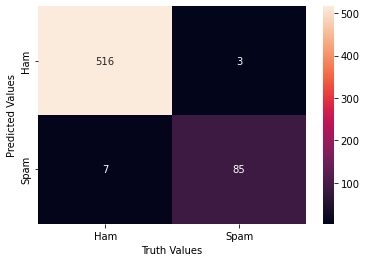

Accuracy: 98.36%
Precision: 96.59%
Recall: 92.39%
F1 score: 94.44%


In [16]:
# Metrics - MultiNomial Naive Bayes
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred)

#matrix_df = pd.DataFrame(matrix, index=["Ham", "Spam"], columns=["Ham", "Spam"])
#confusion_df = matrix_df.astype('float')/matrix_df.sum(axis=1)
s = sns.heatmap(matrix, annot=True, fmt='.3g', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
s.set(xlabel='Truth Values', ylabel='Predicted Values')
plt.show()


print("Accuracy: {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))
print("F1 score: {:.2f}%".format(100 * f1_score(y_test, y_pred)))